# Optimising Portfolio for Sharpe Ratio

### Set up

In [56]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds 

In [2]:
tickers = ['AAPL','INTC','SBUX','GC=F','CL=F', '^GSPC', '^FTSE']
df = yf.download(tickers,start= '2010-01-01')['Adj Close']

[*********************100%%**********************]  7 of 7 completed


In [3]:
df

,AAPL,CL=F,GC=F,INTC,SBUX,^FTSE,^GSPC
Date,,,,,,,
2010-01-04,6.454507,81.510002,1117.699951,13.519423,8.890196,5500.299805,1132.989990
2010-01-05,6.465663,81.769997,1118.099976,13.512953,9.098469,5522.500000,1136.520020
2010-01-06,6.362821,83.180000,1135.900024,13.467627,9.032903,5530.000000,1137.140015
2010-01-07,6.351056,82.660004,1133.099976,13.338135,9.009759,5526.700195,1141.689941
2010-01-08,6.393280,82.750000,1138.199951,13.487049,8.978904,5534.200195,1144.979980
...,...,...,...,...,...,...,...
2024-09-03,222.770004,70.339996,2489.899902,20.100000,93.180000,8298.500000,5528.930176
2024-09-04,220.850006,69.199997,2493.399902,19.430000,92.330002,8269.599609,5520.069824
2024-09-05,222.380005,69.150002,2511.399902,19.400000,91.559998,8241.700195,5503.410156


### Individual security Risk & Return 

In [27]:
ret_df = np.log((df / df.shift(1)))
ret_df.dropna()

/Users/ifechiekekwe/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,AAPL,CL=F,GC=F,INTC,SBUX,^FTSE,^GSPC
Date,,,,,,,
2010-01-05,0.001727,0.003185,0.000358,-0.000479,0.023157,0.004028,0.003111
2010-01-06,-0.016034,0.017097,0.015795,-0.003360,-0.007232,0.001357,0.000545
2010-01-07,-0.001851,-0.006271,-0.002468,-0.009662,-0.002565,-0.000597,0.003993
2010-01-08,0.006626,0.001088,0.004491,0.011103,-0.003431,0.001356,0.002878
2010-01-11,-0.008861,-0.002783,0.010922,0.005745,-0.003011,0.000704,0.001745
...,...,...,...,...,...,...,...
2024-08-29,0.014465,0.018481,0.009828,0.026172,-0.004628,0.004269,-0.000039
2024-08-30,-0.003444,-0.031583,-0.012711,0.090648,-0.003062,-0.000358,0.010042
2024-09-04,-0.008656,-0.016340,0.001405,-0.033902,-0.009164,-0.003489,-0.001604


<Axes: xlabel='Date'>

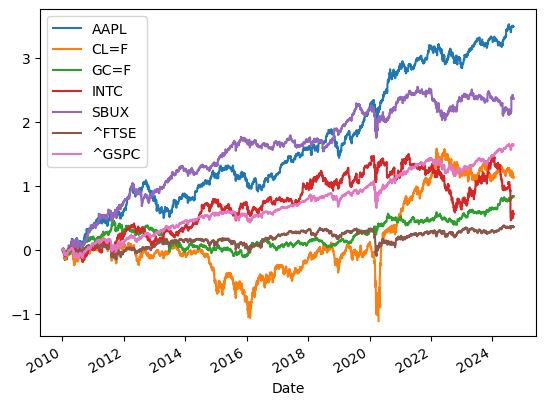

In [28]:
ret_df.cumsum().plot()

In [29]:
ret_df.mean(), ret_df.std(), ret_df.mean() / ret_df.std() 

(AAPL     0.000970
 CL=F     0.000316
 GC=F     0.000235
 INTC     0.000158
 SBUX     0.000655
 ^FTSE    0.000100
 ^GSPC    0.000453
 dtype: float64,
 AAPL     0.017665
 CL=F     0.025634
 GC=F     0.010030
 INTC     0.020308
 SBUX     0.017433
 ^FTSE    0.009945
 ^GSPC    0.010982
 dtype: float64,
 AAPL     0.054885
 CL=F     0.012321
 GC=F     0.023420
 INTC     0.007766
 SBUX     0.037602
 ^FTSE    0.010093
 ^GSPC    0.041250
 dtype: float64)

### Portfolio Risk & Retrun 

In [35]:
#scalable equal weights vector
w = np.ones(len(ret_df.columns)) / (np.ones(len(ret_df.columns))).sum()
w

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [36]:
# covariance matrix
covar_matrix = ret_df.cov()
covar_matrix

,AAPL,CL=F,GC=F,INTC,SBUX,^FTSE,^GSPC
AAPL,0.000312,0.000076,0.000009,0.000164,0.000132,0.000057,0.000133
CL=F,0.000076,0.000657,0.000035,0.000090,0.000070,0.000078,0.000082
GC=F,0.000009,0.000035,0.000101,0.000008,-0.000001,0.000004,0.000005
INTC,0.000164,0.000090,0.000008,0.000412,0.000126,0.000068,0.000141
SBUX,0.000132,0.000070,-0.000001,0.000126,0.000304,0.000064,0.000122
^FTSE,0.000057,0.000078,0.000004,0.000068,0.000064,0.000099,0.000064
^GSPC,0.000133,0.000082,0.000005,0.000141,0.000122,0.000064,0.000121


In [37]:
# Expected Returns
        #dot product fucntion method
portolio_e = ret_df.mean().dot(w)

         #expanded form to show what dot product actually is
portolio_e = (w * ret_df.mean()).sum()

# all the same 

In [38]:
porfolio_r = (w.dot(covar_matrix.dot(w)))**0.5

In [39]:
portolio_e, porfolio_r, portolio_e / porfolio_r

(0.00041240870875607744, 0.01016446844578605, 0.04057356377814842)

### Markowitz Resampled method

In [ ]:
def mrm (weights, df):
    e = weights.dot(df.mean())
    std = weights.dot(df.cov().dot(weights))**0.5
    sharpe = e / std
    return e, std, sharpe

In [ ]:
def give_weights(df):
    rand = np.random.random(len(df.columns)) #create a vector of length n of random numbers 
    rand /= rand.sum() #divding all the these numbers by the sum will ensure all the weights sum to 1.
    return rand

In [ ]:
Returns = []
Risk = []
Sharpe = []
Weights = []

for i in range(0,5000):
    weights = give_weights(ret_df)
    a,b,c = mrm(weights,ret_df)
    Returns.append(a)
    Risk.append(b)
    Sharpe.append(c)
    Weights.append(weights)



In [ ]:
compare = pd.DataFrame({'Returns':Returns,'Risk': Risk ,'Sharpe': Sharpe, 'Weights': Weights})
compare.nlargest(1,'Sharpe')

In [ ]:
compare.plot(x= 'Returns', y='Risk', kind='scatter')

### Scipy Method

In [40]:
def p_sharpe (weights, df):
    e = weights.dot(df.mean())
    std = weights.dot(df.cov().dot(weights))**0.5
    sharpe = e / std
    return -sharpe

In [41]:
w = np.ones(len(ret_df.columns)) / (np.ones(len(ret_df.columns))).sum()
w

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [42]:
cons = ({'type':'eq','fun': lambda x : np.sum(x)-1})

In [43]:
optimal_weights = minimize(p_sharpe,w, ret_df,constraints= cons)['x']
optimal_weights

array([ 0.56966702,  0.01692393,  0.42929626, -0.32634511,  0.21879032,
       -0.37854663,  0.47021422])

### Iterative Method for a 2 stock portfolilo

###### How would I make this work for any number of assets?

In [ ]:
def p_sharpe (weights, df):
    e = weights.dot(df.mean())
    std = weights.dot(df.cov().dot(weights))**0.5
    sharpe = e / std
    return -sharpe

In [ ]:
w = np.arange(0,1,0.001)

In [ ]:
sharpes = []
Weights = []

for i in w:
    weights = w, 1-w
    weights = np.array(weights)   
    print(weights)
    sharpes.append(p_sharpe(weights,ret_df))
    Weights.append(weights)


In [ ]:
compare = pd.DataFrame({'Sharpes': sharpes},index= Weights)
compare

In [ ]:
compare.nsmallest(1)

### Backtest using Scipy Method

In [44]:
training_data = ret_df[:int(len(ret_df)*0.7)]
testing_data = ret_df[int(len(ret_df)*0.7):]


In [45]:
predicted_best_weights = minimize(p_sharpe,w,training_data,constraints= cons)['x']
predicted_best_weights

array([ 0.81983878, -0.37205742,  0.58322235,  0.22796967,  0.8823014 ,
       -0.69751886, -0.44375592])

In [55]:
#compare the returns of this optimal weights to the return of equal weights in test data

predicted_best_sharpe= p_sharpe(predicted_best_weights,testing_data)

equal_weights_sharpe = p_sharpe(w,testing_data) 

predicted_best_sharpe, equal_weights_sharpe

(-0.002592576540122836, -0.057758138355876155)

Wow wtf this model is complete ass

In [ ]:
#to add bounds such as no no short selling
# minimize(p_sharpe,w,training_data,bounds= Bounds(0,1) ,constraints= cons)